In [117]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from matplotlib import cm
from io import StringIO
import pandas as pd
from scipy.optimize import curve_fit
from scipy.integrate import quad

In [3]:
data = fits.open('/Users/natachaupra/Downloads/manga-8135-1902-LOGCUBE.fits.gz')

In [4]:
flux = np.transpose(data['FLUX'].data, axes=(2, 1, 0))
ivar = np.transpose(data['IVAR'].data, axes=(2, 1, 0))
mask = np.transpose(data['MASK'].data, axes=(2, 1, 0))
wave = data['WAVE'].data

In [5]:
mangaid = '1-43214'
redshift = 0.117997
plateifu = '8135-1902'

In [6]:
do_not_use = (mask & 2**10) != 0 

In [181]:
wave_5007 = 5007 * (1 + redshift)
upper_b = 5615 # I changed this from 5630 so you don't have to slice y_ax (And tho lower_b too, from 5580 to 5583)
lower_b = 5583

In [182]:
def func(b, m, c):
            a = (b - c)/m
            return a

In [191]:
OIII_5007 = []
res = []
for x in range (len(flux)): # to get the x pixel index
    for y in range (len(flux[0])): # to get the y pixel index
# for x in range(2, 4):
#     for y in range(2, 4):
        y_ax = np.where(np.logical_and(wave > lower_b, wave < upper_b))[0]    
#         y_ax = y_ax[2:28]

        flux_compare = np.array([]) 
        ivar_compare = np.array([])
        mask_compare = np.array([])
        result = []
        sumresult = []

        for i in y_ax:

            flux_compare = np.append(flux_compare, flux[x,y,i])
            ivar_compare = np.append(ivar_compare, ivar[x,y,i])
            mask_compare = np.append(mask_compare, do_not_use[x,y,i])

        for i in range(len(y_ax)): 
            sigma = np.sqrt(1 / ivar_compare[i]) if ivar_compare[i] != 0 else 0
        
            if flux_compare[i] < (3 * sigma):
                result.append(0)
            else:
                result.append(flux_compare[i])
            sumresult.append(np.sum(result))
            result = []

        index = np.where(y_ax == y_ax[-2])[0][0]


        a = [wave[y_ax[-2]], wave[y_ax[-1]]]
        b = [sumresult[index], sumresult[index + 1]]
        
#         print('a',a)
#         print('b',b)

        m = (b[1] - b[0])/(a[1] - a[0])
#         print('m',m)

        c = b[0] - m*a[0]
    
        if m == 0:
            res.append(0)
        else:
            xval = func(sumresult[0], m, c)
        # error encountered here when m is zero for flux density array where x, y are small.
    
            dlmd = []
            
            xcoord = list(wave[y_ax[0] : y_ax[-1]])
            xcoord.append(xval)
            xcoord = np.array(xcoord)

            ycoord = sumresult[:-1]
            ycoord.append(sumresult[0])
            ycoord = np.array(ycoord)

            for i in range(len(xcoord)-1):
                dlmd.append(xcoord[i+1] - xcoord[i])

            dlmd = np.array(dlmd)

            area = ycoord[0] * dlmd[0] + ycoord[-1] * dlmd[-1]

            for i in range(1, len(ycoord)-1):
                area += ycoord[i] * (dlmd[i-1] + dlmd[i])

            all_under = (1/2) * area

            rectangle = ycoord[0] * (xcoord[-1] - xcoord[0])

            flux_area_5007 = all_under - rectangle

            res.append(flux_area_5007)

    OIII_5007.append(res)
    res = []

Text(0.5, 1.0, '[OIII]5007 flux')

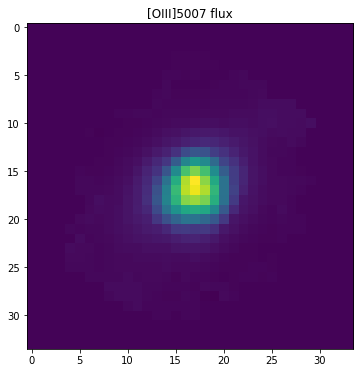

In [198]:
plt.figure(figsize = (6,6))
plt.imshow(OIII_5007)
plt.title('[OIII]5007 flux')

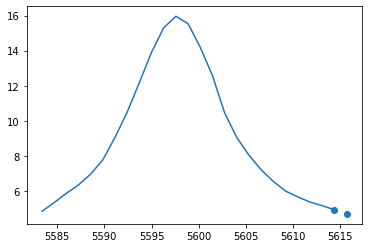

In [115]:
plt.plot(wave[y_ax[0]:y_ax[-1]], flux[17,17][y_ax[0]: y_ax[-1]])
plt.scatter(a, b)

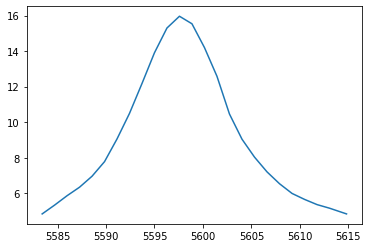

In [116]:
plt.plot(xcoord, ycoord)

In [119]:
def gaussian(x, amp, mean, sigma, base):
    return (amp * np.exp(-(x-mean)**2 / (2*sigma**2))) + base

In [120]:
popt, pcov = curve_fit(gaussian, xcoord, ycoord, p0 = [16, 5598, 15, 4])

In [132]:
popt

array([1.04184207e+01, 5.59767267e+03, 4.63176279e+00, 5.21802004e+00])

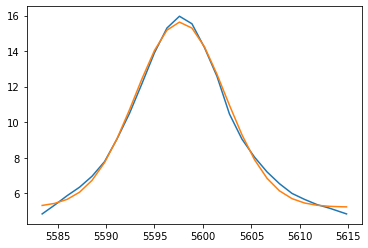

In [121]:
plt.plot(xcoord, ycoord)
plt.plot(xcoord, gaussian(xcoord, *popt))

In [137]:
y = quad(gaussian, lower_b, upper_b, args = (popt[0], popt[1], popt[2], popt[3]))
y

(381.8517693070263, 7.707089455522009e-08)

In [138]:
k = y[0]-(30*3.8)
k

267.8517693070263

In [ ]:
OIII_5007 = []
res = []
# for x in range (len(flux)): # to get the x pixel index
#     for y in range (len(flux[0])): # to get the y pixel index
for x in range(2, 4):
    for y in range(2, 4):
        y_ax = np.where(np.logical_and(wave > lower_b, wave < upper_b))[0]    
        y_ax = y_ax[2:28]
#         print('there', y_ax, len(y_ax))
        
        # you can start by making all of them an array to begin with, so no need for a conversion later
        flux_compare = np.array([]) 
        ivar_compare = np.array([])
        mask_compare = np.array([])
        result = []
        sumresult = []

        for i in y_ax:
            
#             print(type(flux[x,y,i]), flux[x,y,i]) # if you see this line, flux[x,y,i] is already a float (of type
            # numpy float32), so if you try to flatten() it, it will become an array.
            # So essentially what you are doing in the line below is turning float into array and appending that 
            # array into flux_compare array
#             flux_compare.append(flux[x,y,i].flatten())
#             ivar_compare.append(ivar[x,y,i].flatten())
#             mask_compare.append(do_not_use[x,y,i].flatten())


            flux_compare = np.append(flux_compare, flux[x,y,i]) # this should do the job
            ivar_compare = np.append(ivar_compare, ivar[x,y,i])
            mask_compare = np.append(mask_compare, do_not_use[x,y,i])
        print(flux_compare)

#         flux_compare = np.array(flux_compare)
#         ivar_compare = np.array(ivar_compare)
#         mask_compare = np.array(mask_compare)
    

        
        for i in range(len(y_ax)): 
            sigma = np.sqrt(1 / ivar_compare[i]) if ivar_compare[i] != 0 else 0
        
            if flux_compare[i] < (3 * sigma):
                result.append(0)
            else:
                result.append(flux_compare[i])
            sumresult.append(np.sum(result))
            result = []
#         print(sumresult)
    
        index = np.where(y_ax == y_ax[-2])[0][0] # Why are you finding this index ?
#         print(index)

        a = [wave[y_ax[-2]], wave[y_ax[-1]]]
        b = [sumresult[index], sumresult[index + 1]]
        
#         print(a, b)

#         m = (b[1] - b[0])/(b[1] - b[0])
        m = (b[1] - b[0])/(a[1] - a[0])

        c = b[0] - m*a[0]
        
#         print(m, c)
        
#         def func(b, m, c):
#             a = (b - c)/m
#             return a

        xval = func(sumresult[0], m, c)
#         print(xval)
        
#         xcoord = [] # Don't need this. Just slice the wave array and keep it in xcoord like below. 
#         ycoord = [] # Don't need this too. Same reason.
        dlmd = []

#         for i in range(y_ax[0], y_ax[-1]): # Since you can slice wave array, you don't need this loop anymore
#             xcoord.append(wave[i])
            
        xcoord = list(wave[y_ax[0] : y_ax[-1]])
        xcoord.append(xval)
        xcoord = np.array(xcoord)
        
        ycoord = sumresult[:-1]
        ycoord.append(sumresult[0])
        ycoord = np.array(ycoord)
    
#         print('xcoord',xcoord, type(xcoord))
#         print('ycoord',ycoord, type(ycoord))
        
        # You don't need this block anymore 
        
#         xcoord.append(xval)
#         print('xcoord', xcoord)
#         ycoord = sumresult[:-1]
#         print('ycoord', ycoord)
#         ycoord.append(sumresult[0])
#         print('ycoord', ycoord)

        # you can do this method here, instead of the one below, to eliminate all the loops
#         dlmd = (xcoord[-1] - xcoord[0])/len(xcoord)
#         print(dlmd)

#         area = (1/2)*(dlmd)*(ycoord[0] + ycoord[-1] + np.sum(2*(ycoord[1:-1])))
#         print(area)
        
        for i in range(len(xcoord)-1):
            dlmd.append(xcoord[i+1] - xcoord[i])
#         print(dlmd)
            
        dlmd = np.array(dlmd)

        area = ycoord[0] * dlmd[0] + ycoord[-1] * dlmd[-1]

        for i in range(1, len(ycoord)-1):
            area += ycoord[i] * (dlmd[i-1] + dlmd[i])

        all_under = (1/2) * area

        rectangle = ycoord[0] * (xcoord[-1] - xcoord[0])

        flux_area_5007 = all_under - rectangle

        res.append(flux_area_5007)

    OIII_5007.append(res)
    res = []
        
# print (len(OIII_5007))